# Historical Text Normalization: sequence-to-sequence model (seq2seq)


In order to implement this sequence-to-sequence model, we need:
* An encoder LSTM. Its input: Historical word form (e.g. "meynteigne"). The encoder produces a vector representation of the input, which is then fed into:
* A decoder LSTM. Produces the normalized word form (e.g. "maintain"). It decodes the given vector into the desired output. 

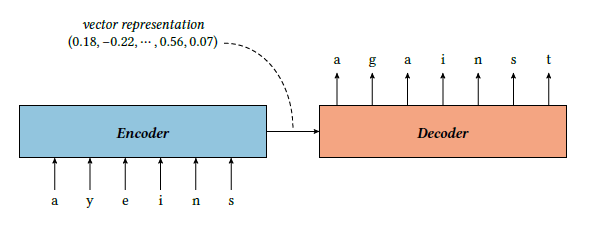

Image: Basic encoder-decoder architecture for normalization (Figure 6.1, Bollmann 2018, p.85)

## Setup: import modules

In [1]:
import numpy as np
import tensorflow as tf #if there are errors: pip3 install tensorflow on anaconda prompt
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import os
import re

## Downloading the data: ICAMET corpus

Note: the ICAMET Corpus is already divided into **dev**, **test** and **train** sets
<p> The files of the ICAMET Corpus have been converted to text files and they should be stored locally in the same path as the present jupyter notebook </p>


In [2]:
notebook_path =os.path.abspath('seq2seq.ipynb')
dev_en = os.path.join(os.path.dirname(notebook_path),'icamet_en-hs_dev_en.txt') 
dev_hs = os.path.join(os.path.dirname(notebook_path),'icamet_en-hs_dev_hs.txt')
train_hs = os.path.join(os.path.dirname(notebook_path),'icamet_en-hs_train_hs.txt')
train_en = os.path.join(os.path.dirname(notebook_path),'icamet_en-hs_train_en.txt') 
test_hs = os.path.join(os.path.dirname(notebook_path),'icamet_en-hs_test_hs.txt')
test_en = os.path.join(os.path.dirname(notebook_path),'icamet_en-hs_test_en.txt')
#print(dev_en + '\n' + dev_hs + '\n' + train_en + '\n' + train_hs + '\n' + test_en + '\n' + test_hs)

Next step: read the data and save them in variables. Each sentence in the text is separated by an empty line. We add start of string and end of string token for the normalized version of the sequences

based on: https://stackabuse.com/python-for-nlp-neural-machine-translation-with-seq2seq-in-keras/ 

In [3]:
#train set
with open(train_hs, encoding='utf8') as hs_raw_train:
    input_train = hs_raw_train.read().strip().split('\n')
    input_train = [x for x in input_train if x] #get rid of empty strings in list

with open(train_en, encoding='utf8') as en_raw_train:
    target_train = en_raw_train.read().strip().split('\n')
    target_train = [x for x in target_train if x]
    output_train = [item + ' <eos>' for item in target_train] #end of string token
    output_input_train = ['<sos> ' + item for item in target_train] #start of string token

#print a random word
print(input_train[10]) 
print(output_train[10])
print(output_input_train[10])

wysest
wisest <eos>
<sos> wisest


In [4]:
print("num input train:", len(input_train))
print("num output train:", len(output_train))
print("num output input train:", len(output_input_train))
#let's have a look how the input and outputs look like
print(input_train[:10])
print(output_train[:10])
print(output_input_train[:10])

num input train: 148622
num output train: 148622
num output input train: 148622
['To', 'the', 'moost', 'noble', '&', 'Worthiest', 'Lordes', 'moost', 'ryghtful', '&']
['To <eos>', 'the <eos>', 'most <eos>', 'noble <eos>', 'and <eos>', 'worthiest <eos>', 'Lords <eos>', 'most <eos>', 'rightful <eos>', 'and <eos>']
['<sos> To', '<sos> the', '<sos> most', '<sos> noble', '<sos> and', '<sos> worthiest', '<sos> Lords', '<sos> most', '<sos> rightful', '<sos> and']


In [5]:
#dev set
with open(dev_hs, encoding='utf8') as hs_raw_dev:
    input_dev  = hs_raw_dev.read().split('\n')
    input_dev = [x for x in input_dev if x]
with open(dev_en, encoding='utf8') as en_raw_dev:
    target_dev = en_raw_dev.read().split('\n')
    target_dev = [x for x in target_dev if x]
    output_dev = [item + ' <eos>' for item in target_dev] #add end of string character
    output_input_dev = ['<sos> ' + item for item in target_dev] #add start of string character
    
print("num input dev:", len(input_dev))
print("num output dev:", len(output_dev))
print("num output input dev:", len(output_input_dev))

#test set
with open(test_hs, encoding='utf8') as hs_raw_test:
    input_test = hs_raw_test.read().split('\n')
    input_test = [x for x in input_test if x]
with open(test_en, encoding='utf8') as en_raw_test:
    target_test = en_raw_test.read().split('\n')
    target_test = [x for x in target_test if x]
    output_test = [item + ' <eos>' for item in target_test] #add end of string character
    output_input_test = ['<sos> ' + item for item in target_test] #add start of string character

print("num input test:", len(input_test))
print("num output test:", len(output_test))
print("num output input test:", len(output_input_test))


num input dev: 16427
num output dev: 16427
num output input dev: 16427
num input test: 17764
num output test: 17764
num output input test: 17764


**How does the data look like?** One word per line, without context 

**How many input tokens do the 3 data sets have?** dev set:16'427 /train set: 148'622/test set: 17'764 

## Step 1: preprocessing the data
### Lowercasing, punctuation removal and padding  

* **Punctuation:** removing punctuation means removing noise (=cleaning the data). Thus, should we remove punctuation? <p> In our Historical English texts, we find many instances where "&" is present and translated into Modern English "and". </p> 
<p> Also, there are abbrevations such as "M." where we can't get rid of the final dot. </p>
<p> - the hyphen is an important punctuation sign that appears often in Historical English, as it is part of the original orthography </p>
<p> Based on these observations, we will remove all other punctuation signs </p>

In [6]:
def clean_data(txt):
    filtered_words = []
    for i in txt:
        x=re.sub(r"[?!\/,\\(@\[){}%°~^\]+£=#$\*\)\"^]","",i)
        #x = [txt[i].lower() for i in range(len(txt))]
        #[punct_in_dev[i].lower() for i in range(len(punct_in_dev))]
        filtered_words.append(x)
    return filtered_words

#storing punctuation free text
punct_in_dev = clean_data(input_dev)
punct_out_dev = clean_data(output_dev)
punct_in_out_dev = clean_data(output_input_dev)

punct_in_train = clean_data(input_train)
punct_out_train = clean_data(output_train)
punct_in_out_train = clean_data(output_input_train)



punct_in_test = clean_data(input_test)
punct_out_test = clean_data(output_test)
punct_in_out_test = clean_data(output_input_test)

* **Lowercasing:** Lowercasing is an important pre-processing step, as we have capitalization at the beginning of the sentence and in particular NE (as in proper nouns)-> for the sake of simplicity
<p> the lower() method turns all characters into lower case </p>

In [7]:
in_dev = [punct_in_dev[i].lower() for i in range(len(punct_in_dev))]
out_dev = [punct_out_dev[i].lower() for i in range(len(punct_out_dev))]
in_out_dev = [punct_in_out_dev[i].lower() for i in range(len(punct_in_out_dev))]

in_train = [punct_in_train[i].lower() for i in range(len(punct_in_train))]
out_train = [punct_out_train[i].lower() for i in range(len(punct_out_train))]
in_out_train = [punct_in_out_train[i].lower() for i in range(len(punct_in_out_train))]

in_test = [punct_in_test[i].lower() for i in range(len(punct_in_test))]
out_test = [punct_out_test[i].lower() for i in range(len(punct_out_test))]
in_out_test = [punct_in_out_test[i].lower() for i in range(len(punct_in_out_test))]

print(in_train[10000:10010])
print(out_train[10000:10010])
print(in_out_train[10000:10010])

['to', 'revive', 'their', 'herts', 'and', 'putt', 'theym', 'in', 'good', 'trust']
['to <eos>', 'revive <eos>', 'their <eos>', 'hearts <eos>', 'and <eos>', 'put <eos>', 'them <eos>', 'in <eos>', 'good <eos>', 'trust <eos>']
['<sos> to', '<sos> revive', '<sos> their', '<sos> hearts', '<sos> and', '<sos> put', '<sos> them', '<sos> in', '<sos> good', '<sos> trust']


* **Padding**: all input arrays should be of the same length. As words have different lengths, we need to add zeros on the left/right so that they all have the same length. Why? Because the LSTM expects input sequences of the same length. We need to convert the sequences into fixed-length vectors, which is done via padding

In [8]:
#let's see how long the longest words are
#input sequences
max_seq_len_in_dev = max([len(item) for item in input_dev])
max_seq_len_in_train = max([len(item) for item in input_train])
max_seq_len_in_test = max([len(item) for item in input_test])

print("max sequence length in input_dev: " + str(max_seq_len_in_dev))
print("max sequence length in input_train: " + str(max_seq_len_in_train))
print("max sequence length in input_test: " + str(max_seq_len_in_test))

#output sequences
max_seq_len_out_dev = max([len(item) for item in target_dev])
max_seq_len_out_train = max([len(item) for item in target_train])
max_seq_len_out_test = max([len(item) for item in target_test])

print("max sequence length in target_dev: " + str(max_seq_len_out_dev))
print("max sequence length in target_train: " + str(max_seq_len_out_train))
print("max sequence length in target_test: " + str(max_seq_len_out_test))

max sequence length in input_dev: 19
max sequence length in input_train: 22
max sequence length in input_test: 18
max sequence length in target_dev: 18
max sequence length in target_train: 19
max sequence length in target_test: 15


* The longest words in the input sequences in Historical English are of length 19, 22 and 18
* The longest words in the output sequences in Modern English are of length 19, 18 and 15
* The length of the longest words will be used to determine the length for padding
* To determine the shape of the encoder and decoder, we need the number of unique tokens in each set (= vocabulary size)

In [9]:
#count the numbers of unique words in the texts and sort them alphabetically
#input sequences
#unique_in_dev(set(sorted(list(in_dev))))
unique_in_dev = set(in_dev)
#unique_in_dev = sorted(list(unique_in_dev))
num_unique_in_dev = len(unique_in_dev)

unique_in_train = set(in_train)
#unique_in_train = set(in_train)
#unique_in_train = sorted(list(unique_in_train))
num_unique_in_train = (len(unique_in_train))

#unique_in_test = set(sorted(list(in_test)))
unique_in_test = set(in_test)
#unique_in_test = sorted(list(unique_in_test))
num_unique_in_test = len(unique_in_test)

#output sequences
#unique_out_dev = set(sorted(list(out_dev)))
unique_out_dev = set(out_dev)
num_unique_out_dev = len(unique_out_dev)

unique_out_train = set(out_train)
num_unique_out_train = len(unique_out_train)

#unique_out_test = set(sorted(list(out_test)))
unique_out_test = set(out_test)
#unique_out_test = sorted(list(unique_out_test))
num_unique_out_test = len(unique_out_test)

print("Number of unique tokens in input dev: " + str(num_unique_in_dev))
print("Number of unique tokens in input train: " + str(num_unique_in_train))
print("Number of unique tokens in input test: " + str(num_unique_in_test))
print("Number of unique tokens in output dev: " + str(num_unique_out_dev))
print("Number of unique tokens in output train: " + str(num_unique_out_train))
print("Number of unique tokens in output test: " + str(num_unique_out_test))

Number of unique tokens in input dev: 4346
Number of unique tokens in input train: 18002
Number of unique tokens in input test: 4529
Number of unique tokens in output dev: 2946
Number of unique tokens in output train: 9855
Number of unique tokens in output test: 2946


**Padding:** A Keras Module will be used so that all elements in the texts have the same length
* word_index attribute of the Tokenizer class: returns a word-to-index dictionary. Words = keys; integers = values

In [12]:

input_tokenizer = Tokenizer(num_words=len(in_train))
#print(input_tokenizer)
input_tokenizer.fit_on_texts(in_train)
index_input_train = input_tokenizer.word_index
#converts words to integers
input_int_seq_train = input_tokenizer.texts_to_sequences(in_train) #will be used for padding

print(len(index_input_train)) #number of unique tokens: vocabulary size
#print(index_input_train) #dict: each word is mapped to an unique integer

17716


In [13]:
output_tokenizer = Tokenizer(num_words=len(out_train))
output_tokenizer.fit_on_texts(out_train + in_out_train)
index_output_train = output_tokenizer.word_index
output_int_seq_train = output_tokenizer.texts_to_sequences(out_train)
output_input_int_seq_train = output_tokenizer.texts_to_sequences(in_out_train)
print(len(index_output_train))
print(index_output_train)

9672
{'eos': 1, 'sos': 2, 'the': 3, 'and': 4, 'to': 5, 'i': 6, 'of': 7, 'you': 8, 'that': 9, 'in': 10, 'your': 11, 'for': 12, 'my': 13, 'as': 14, 'be': 15, 'it': 16, 'have': 17, 'a': 18, 'me': 19, 'is': 20, 'not': 21, 'this': 22, 'his': 23, 'with': 24, 'which': 25, 'he': 26, 'will': 27, 'so': 28, 'at': 29, 'but': 30, 'by': 31, 'all': 32, 'shall': 33, 'him': 34, 'good': 35, 'has': 36, 'if': 37, 'was': 38, 'they': 39, 'do': 40, 'our': 41, 'from': 42, 'may': 43, 'we': 44, 'them': 45, 'or': 46, 'most': 47, 'her': 48, 'would': 49, 'no': 50, 'had': 51, 'any': 52, 'am': 53, 'lord': 54, 'god': 55, 'more': 56, 'well': 57, 'there': 58, 'sir': 59, 'are': 60, 'time': 61, 'said': 62, 'should': 63, 'unto': 64, 'much': 65, 'can': 66, 'great': 67, 'now': 68, 'been': 69, 'very': 70, 'other': 71, 'their': 72, 'yet': 73, 'she': 74, 'one': 75, 'upon': 76, 'were': 77, 'come': 78, 'some': 79, 'such': 80, 'than': 81, 'us': 82, 'grace': 83, 'day': 84, 'what': 85, 'here': 86, 'send': 87, 'king': 88, 'right': 8

In [14]:
#apply padding to the input sequences
encoder_input_train = pad_sequences(input_int_seq_train, maxlen=max_seq_len_in_train, padding='post')
print("encoder_input_sequences_train.shape: ", encoder_input_train.shape)
print("encoder_input_sequences_train[10]: ", encoder_input_train[10])

print(list(index_input_train.keys())[list(index_input_train.values()).index(10)])
#print(index_input_train["selfe"])

encoder_input_sequences_train.shape:  (148622, 22)
encoder_input_sequences_train[10]:  [2758    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
my


The historical English word **selfe** at index 192 is printed above with its padded input shape. There are 152900 sequences in the input and each input sequence will be of length 22 (shape: 152900, 22) 

In [15]:
#apply padding to the output sequences
decoder_input_train = pad_sequences(output_int_seq_train, maxlen=max_seq_len_out_train, padding='post')
print("decoder_input_sequences_train.shape: ", decoder_input_train.shape)
print("decoder_input_sequences_train[10]: ", decoder_input_train[10])
print(list(index_output_train.keys())[list(index_output_train.values()).index(10)])

decoder_input_sequences_train.shape:  (148622, 19)
decoder_input_sequences_train[10]:  [1728    1    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0]
in


In [16]:
#encoder_input_dev = np.zeros(
#(len(input_dev), max_seq_len_in_dev, num_unique_in_dev), dtype="float32")

#print(encoder_input_dev)

### Approach 2: read in sentences with start and end of string token and tokenize later

In [17]:
with open(train_hs, encoding='utf8') as hs_raw_train:
    input_train2 = hs_raw_train.read().strip().split('\n\n')
    input_train2 = [w.replace('\n', ' ') for w in input_train2]

with open(train_en, encoding='utf8') as en_raw_train:
    target_train2 = en_raw_train.read().strip().split('\n')
    target_train2 = [w.replace('\n', ' ') for w in input_train2]
    output_train2 = [item + ' <eos>' for item in target_train2] #end of string token
    output_input_train2 = ['<sos> ' + item for item in target_train2] #start of string token

print(input_train2[10]) 
print(output_train2[10])
print(output_input_train2[10])
        

And nought oonlich vnshewed or hidde it hath be by man now but also of bifore tyme the moost profitable poyntes of trewe gouernaunce of the Citee compiled togidre bi longe labour of discrete & wyse men wyth-out conseille of trewe men for thei sholde nought be knowen ne contynued in the tyme of Nichol Exton Mair outerliche were brent
And nought oonlich vnshewed or hidde it hath be by man now but also of bifore tyme the moost profitable poyntes of trewe gouernaunce of the Citee compiled togidre bi longe labour of discrete & wyse men wyth-out conseille of trewe men for thei sholde nought be knowen ne contynued in the tyme of Nichol Exton Mair outerliche were brent <eos>
<sos> And nought oonlich vnshewed or hidde it hath be by man now but also of bifore tyme the moost profitable poyntes of trewe gouernaunce of the Citee compiled togidre bi longe labour of discrete & wyse men wyth-out conseille of trewe men for thei sholde nought be knowen ne contynued in the tyme of Nichol Exton Mair outer

In [18]:
#number of sentences in train
print('num input:', len(input_train2))
print('num output', len(output_train2))
print('num output input', len(output_input_train2))

num input: 4277
num output 4277
num output input 4277


In [19]:
def clean_data(txt):
    filtered_words = []
    for i in txt:
        x=re.sub(r"[?!\/,\\(@\[){}%°~^\]+£=#$\*\)\"^]","",i)
        #x = [txt[i].lower() for i in range(len(txt))]
        #[punct_in_dev[i].lower() for i in range(len(punct_in_dev))]
        filtered_words.append(x)
    return filtered_words

punct_in_train2 = clean_data(input_train2)
punct_out_train2 = clean_data(output_train2)
punct_in_out_train2 = clean_data(output_input_train2)

In [20]:
in_train2 = [punct_in_train2[i].lower() for i in range(len(punct_in_train2))]
out_train2 = [punct_out_train2[i].lower() for i in range(len(punct_out_train2))]
in_out_train2 = [punct_in_out_train2[i].lower() for i in range(len(punct_in_out_train2))]

#print(in_train2)
#print(out_train2)
#print(in_out_train2)

In [21]:
print(len(in_train2))

4277


In [22]:
input_tokenizer2 = Tokenizer(num_words=4277)
input_tokenizer2.fit_on_texts(in_train2)
index_input_train2 = input_tokenizer2.word_index
input_int_seq_train2 = input_tokenizer2.texts_to_sequences(in_train2) #will be used for padding

max_input_len = max(len(sen) for sen in input_int_seq_train2)

print(len(index_input_train2)) #number of unique tokens: vocabulary size
print("Length of longest sentence in input: %g" % max_input_len)
print(index_input_train2) #dict: each word is mapped to an unique integer

17716
Length of longest sentence in input: 403
{'the': 1, 'to': 2, 'and': 3, 'i': 4, 'of': 5, 'that': 6, 'you': 7, 'in': 8, 'for': 9, 'my': 10, 'your': 11, 'as': 12, 'be': 13, 'a': 14, 'me': 15, 'it': 16, 'not': 17, 'have': 18, 'is': 19, 'he': 20, 'his': 21, 'this': 22, 'but': 23, 'at': 24, 'so': 25, 'with': 26, 'by': 27, 'will': 28, 'which': 29, 'all': 30, 'good': 31, 'was': 32, 'shall': 33, 'or': 34, 'may': 35, 'they': 36, 'if': 37, 'from': 38, 'most': 39, 'we': 40, 'our': 41, 'ye': 42, 'him': 43, 'them': 44, 'hath': 45, 'had': 46, 'any': 47, 'god': 48, 'am': 49, 'no': 50, 'her': 51, 'more': 52, 'haue': 53, 'do': 54, 'yow': 55, 'can': 56, 'lord': 57, 'now': 58, 'well': 59, 'are': 60, 'other': 61, 'much': 62, 'then': 63, 'grace': 64, 'mr': 65, 'there': 66, 'day': 67, 'very': 68, 'hym': 69, 'on': 70, 'she': 71, 'what': 72, 'one': 73, 'some': 74, 'tyme': 75, 'send': 76, 'were': 77, 'unto': 78, 'yet': 79, 'here': 80, 'come': 81, 'their': 82, 'when': 83, 'make': 84, 'pray': 85, 'upon': 86

In [23]:
output_tokenizer2 = Tokenizer(num_words=4277, filters='')
output_tokenizer2.fit_on_texts(out_train2 + in_out_train2)
index_output_train2 = output_tokenizer2.word_index
output_int_seq_train2 = output_tokenizer2.texts_to_sequences(out_train2)
output_input_int_seq_train = output_tokenizer2.texts_to_sequences(in_out_train2)

max_out_len = max(len(sen) for sen in output_int_seq_train2)

print(len(index_output_train2))
print(index_output_train2)

17905
{'the': 1, 'to': 2, 'and': 3, 'i': 4, 'of': 5, 'that': 6, 'you': 7, 'in': 8, '<eos>': 9, '<sos>': 10, 'for': 11, 'my': 12, 'your': 13, 'as': 14, 'be': 15, 'a': 16, 'me': 17, 'it': 18, 'not': 19, 'have': 20, 'is': 21, 'he': 22, 'his': 23, 'this': 24, 'but': 25, 'at': 26, 'so': 27, 'with': 28, 'by': 29, 'will': 30, 'which': 31, 'all': 32, 'good': 33, 'was': 34, 'shall': 35, 'or': 36, 'may': 37, '&': 38, 'they': 39, 'if': 40, 'from': 41, 'most': 42, 'we': 43, 'our': 44, 'ye': 45, 'him': 46, 'them': 47, 'hath': 48, 'had': 49, 'any': 50, 'god': 51, 'am': 52, 'no': 53, 'her': 54, 'more': 55, 'haue': 56, 'do': 57, 'yow': 58, 'can': 59, 'lord': 60, 'now': 61, 'are': 62, 'well': 63, 'other': 64, 'much': 65, 'then': 66, 'grace': 67, 'there': 68, 'very': 69, 'day': 70, 'hym': 71, 'on': 72, 'she': 73, 'what': 74, 'one': 75, 'some': 76, 'tyme': 77, 'send': 78, 'were': 79, 'unto': 80, 'yet': 81, 'here': 82, 'come': 83, 'their': 84, 'when': 85, 'make': 86, 'pray': 87, 'upon': 88, 'such': 89, 'a

In [24]:
encoder_input_sequences = pad_sequences(input_int_seq_train2, maxlen= max_input_len)
print(encoder_input_sequences.shape)
print(encoder_input_sequences[10])
print(list(index_input_train2.keys())[list(index_input_train2.values()).index(30)])

(4277, 403)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0

In [25]:
print(index_input_train2['wisest'])

7191


In [26]:
decoder_input_sequences = pad_sequences(output_int_seq_train2, maxlen=max_out_len, padding='post')
print("decoder_input_sequences.shape:", decoder_input_sequences.shape)
print("decoder_input_sequences[172]:", decoder_input_sequences[172])
print(list(index_output_train2.keys())[list(index_output_train2.values()).index(30)])

decoder_input_sequences.shape: (4277, 407)
decoder_input_sequences[172]: [  13    5  966    3   23  318   31   46 3658   20  161    3    8   72
    1    8   32   24    9    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    

## Step 2: Set params
Here, we set the batch size for training, the number of epochs for training

In [16]:
batch_size = 64 #TODO what batch size makes sense?
epochs = 10 #to test with, to see how well it performs
latent_dim = 256

## Step 3: Build the model

Create the encoder-decoder model. The encoder reads the input sequence and the decoder predicts the output sequence (1 character per output)
* accuracy model -> use accuracy as a metric for evaluating how well the model performs
* loss function -> TODO what loss function makes sense?
* optimizer

## 3.1 Encoder
**Input of the encoder:** sequence of characters as one-hot vectors with num_encoder_tokens (the length of the input characters)

In [17]:
from keras.layers import LSTM

num_encoder_tokens = len(index_input_train)
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]



## 3.2 Decoder

In [18]:
from keras.layers import Dense
num_decoder_tokens = len(index_output_train)
decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))
decoder = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _,_ = decoder(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation= 'softmax')
decoder_outputs = decoder_dense(decoder_outputs)

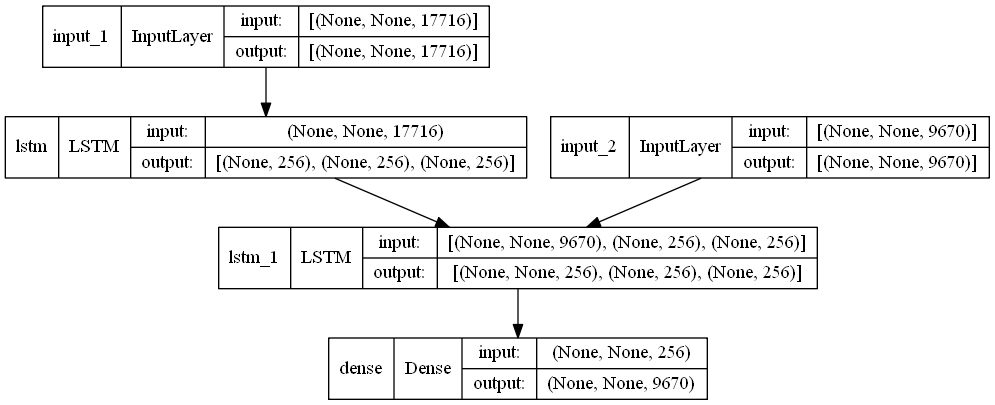

In [19]:
from keras.models import Model
from tensorflow.keras.utils import plot_model
#generate accuracy measurement
#it takes encoder and decoder input layer as an array of inputs
#and the decoder LSTM as the output

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

## Step 4: Train the model

In [20]:
model.compile(optimizer=" ", loss=" ", metrics=["accuracy"])


model.fit()

model.save("seq2seq")

model.summary()

ValueError: Unknown optimizer:  . Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

## Step 5: Test the model --> making predictions
Testing with input_test from ICAMET corpus and ARCHER corpus (first century 1600-1700) to see how well the model performs

**evaluation metrics** 

accuracy: compare with the number of words that don't need to be changed 

precision and recall -> for words that the algorithm changed something / gold standard cases